In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
#!pip install segmentation_models_pytorch
from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
IMAGE_PATH = '/content/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/dataset/semantic_drone_dataset/label_images_semantic/'

In [23]:
n_classes = 23

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [24]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


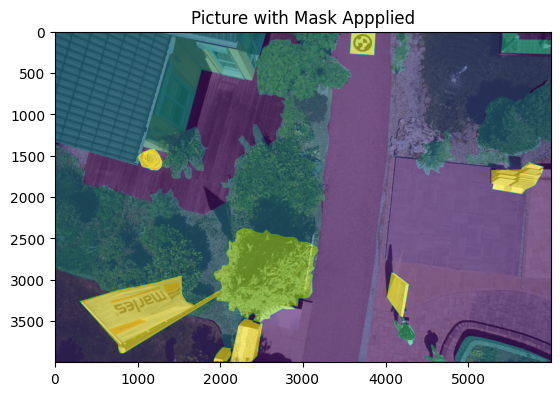

In [25]:
img = Image.open(IMAGE_PATH + df['id'][99] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][99] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [26]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768)
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [27]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 6

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [28]:
model = smp.FPN(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    classes=23,
    activation=None
)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


In [29]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [30]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight
            optimizer.zero_grad() #reset gradient

            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))


            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [31]:
max_lr = 1e-3
epoch = 30
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 0.921 
Epoch:1/30.. Train Loss: 2.398.. Val Loss: 0.921.. Train mIoU:0.092.. Val mIoU: 0.201.. Train Acc:0.465.. Val Acc:0.752.. Time: 3.89m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.921 >> 0.700 
Epoch:2/30.. Train Loss: 1.222.. Val Loss: 0.700.. Train mIoU:0.209.. Val mIoU: 0.265.. Train Acc:0.666.. Val Acc:0.796.. Time: 3.89m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.700 >> 0.645 
Epoch:3/30.. Train Loss: 1.004.. Val Loss: 0.645.. Train mIoU:0.281.. Val mIoU: 0.362.. Train Acc:0.718.. Val Acc:0.826.. Time: 3.85m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/30.. Train Loss: 1.092.. Val Loss: 0.969.. Train mIoU:0.297.. Val mIoU: 0.251.. Train Acc:0.703.. Val Acc:0.735.. Time: 3.86m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.969 >> 0.712 
saving model...
Epoch:5/30.. Train Loss: 1.017.. Val Loss: 0.712.. Train mIoU:0.284.. Val mIoU: 0.324.. Train Acc:0.717.. Val Acc:0.786.. Time: 3.87m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.712 >> 0.699 
Epoch:6/30.. Train Loss: 0.910.. Val Loss: 0.699.. Train mIoU:0.317.. Val mIoU: 0.316.. Train Acc:0.739.. Val Acc:0.792.. Time: 3.84m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:7/30.. Train Loss: 0.976.. Val Loss: 0.775.. Train mIoU:0.300.. Val mIoU: 0.291.. Train Acc:0.721.. Val Acc:0.784.. Time: 3.84m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.775 >> 0.604 
Epoch:8/30.. Train Loss: 0.833.. Val Loss: 0.604.. Train mIoU:0.329.. Val mIoU: 0.353.. Train Acc:0.754.. Val Acc:0.821.. Time: 3.87m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.604 >> 0.509 
Epoch:9/30.. Train Loss: 0.777.. Val Loss: 0.509.. Train mIoU:0.354.. Val mIoU: 0.399.. Train Acc:0.772.. Val Acc:0.847.. Time: 3.85m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.509 >> 0.452 
Epoch:10/30.. Train Loss: 0.629.. Val Loss: 0.452.. Train mIoU:0.394.. Val mIoU: 0.420.. Train Acc:0.810.. Val Acc:0.861.. Time: 3.88m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:11/30.. Train Loss: 0.809.. Val Loss: 0.688.. Train mIoU:0.366.. Val mIoU: 0.344.. Train Acc:0.769.. Val Acc:0.797.. Time: 3.90m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.688 >> 0.585 
saving model...
Epoch:12/30.. Train Loss: 0.782.. Val Loss: 0.585.. Train mIoU:0.354.. Val mIoU: 0.371.. Train Acc:0.770.. Val Acc:0.827.. Time: 3.89m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.585 >> 0.460 
Epoch:13/30.. Train Loss: 0.588.. Val Loss: 0.460.. Train mIoU:0.422.. Val mIoU: 0.435.. Train Acc:0.822.. Val Acc:0.863.. Time: 3.88m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.460 >> 0.412 
Epoch:14/30.. Train Loss: 0.522.. Val Loss: 0.412.. Train mIoU:0.444.. Val mIoU: 0.464.. Train Acc:0.840.. Val Acc:0.875.. Time: 3.89m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.412 >> 0.408 
Epoch:15/30.. Train Loss: 0.473.. Val Loss: 0.408.. Train mIoU:0.465.. Val mIoU: 0.468.. Train Acc:0.851.. Val Acc:0.878.. Time: 3.86m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.408 >> 0.369 
Epoch:16/30.. Train Loss: 0.460.. Val Loss: 0.369.. Train mIoU:0.480.. Val mIoU: 0.495.. Train Acc:0.856.. Val Acc:0.889.. Time: 3.87m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.369 >> 0.358 
saving model...
Epoch:17/30.. Train Loss: 0.420.. Val Loss: 0.358.. Train mIoU:0.496.. Val mIoU: 0.502.. Train Acc:0.868.. Val Acc:0.893.. Time: 3.83m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.358 >> 0.347 
Epoch:18/30.. Train Loss: 0.380.. Val Loss: 0.347.. Train mIoU:0.517.. Val mIoU: 0.512.. Train Acc:0.879.. Val Acc:0.895.. Time: 3.88m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.347 >> 0.338 
Epoch:19/30.. Train Loss: 0.361.. Val Loss: 0.338.. Train mIoU:0.525.. Val mIoU: 0.521.. Train Acc:0.884.. Val Acc:0.896.. Time: 3.86m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:20/30.. Train Loss: 0.360.. Val Loss: 0.338.. Train mIoU:0.543.. Val mIoU: 0.524.. Train Acc:0.886.. Val Acc:0.899.. Time: 3.84m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.338 >> 0.335 
Epoch:21/30.. Train Loss: 0.337.. Val Loss: 0.335.. Train mIoU:0.542.. Val mIoU: 0.540.. Train Acc:0.891.. Val Acc:0.906.. Time: 3.86m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.335 >> 0.326 
Epoch:22/30.. Train Loss: 0.320.. Val Loss: 0.326.. Train mIoU:0.550.. Val mIoU: 0.543.. Train Acc:0.896.. Val Acc:0.908.. Time: 3.84m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.326 >> 0.306 
saving model...
Epoch:23/30.. Train Loss: 0.296.. Val Loss: 0.306.. Train mIoU:0.557.. Val mIoU: 0.551.. Train Acc:0.904.. Val Acc:0.911.. Time: 3.84m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 5 time
Epoch:24/30.. Train Loss: 0.301.. Val Loss: 0.310.. Train mIoU:0.573.. Val mIoU: 0.553.. Train Acc:0.902.. Val Acc:0.909.. Time: 3.77m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.310 >> 0.304 
Epoch:25/30.. Train Loss: 0.292.. Val Loss: 0.304.. Train mIoU:0.573.. Val mIoU: 0.547.. Train Acc:0.904.. Val Acc:0.912.. Time: 3.77m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.304 >> 0.297 
Epoch:26/30.. Train Loss: 0.286.. Val Loss: 0.297.. Train mIoU:0.582.. Val mIoU: 0.558.. Train Acc:0.906.. Val Acc:0.913.. Time: 3.78m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 6 time
Epoch:27/30.. Train Loss: 0.272.. Val Loss: 0.304.. Train mIoU:0.591.. Val mIoU: 0.552.. Train Acc:0.910.. Val Acc:0.912.. Time: 3.76m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Decreasing.. 0.304 >> 0.297 
Epoch:28/30.. Train Loss: 0.261.. Val Loss: 0.297.. Train mIoU:0.600.. Val mIoU: 0.557.. Train Acc:0.914.. Val Acc:0.914.. Time: 3.79m


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Loss Not Decrease for 7 time
Loss not decrease for 7 times, Stop Training
Total time: 111.54 m


In [32]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

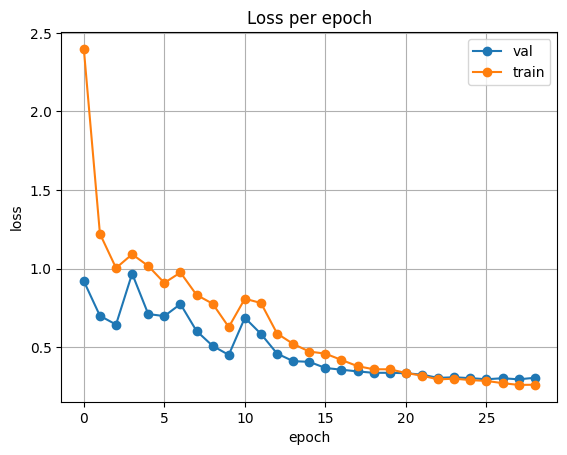

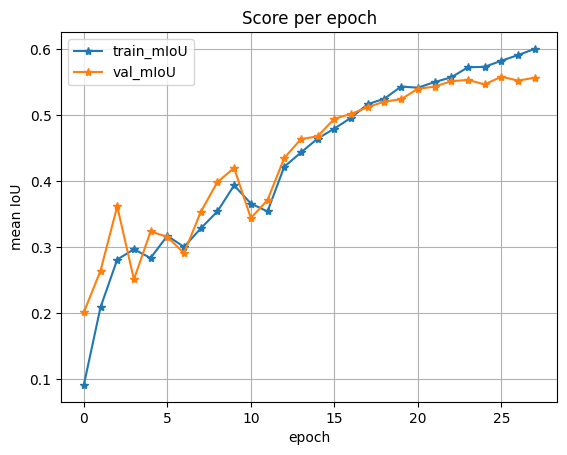

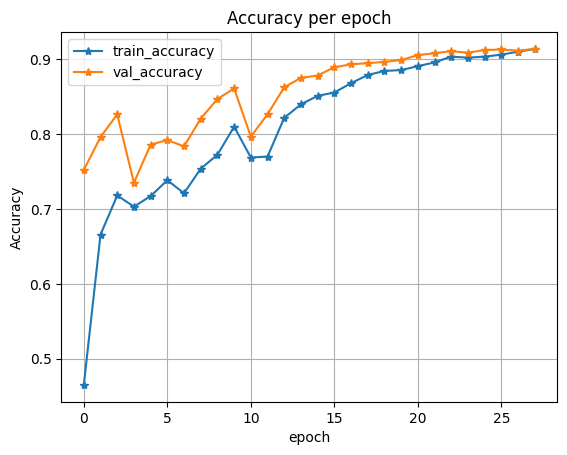

In [33]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [34]:
class DroneTestDataset(Dataset):

    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        mask = torch.from_numpy(mask).long()

        return img, mask


In [35]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [36]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [37]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():

        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [38]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)

mob_miou = miou_score(model, test_set)
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

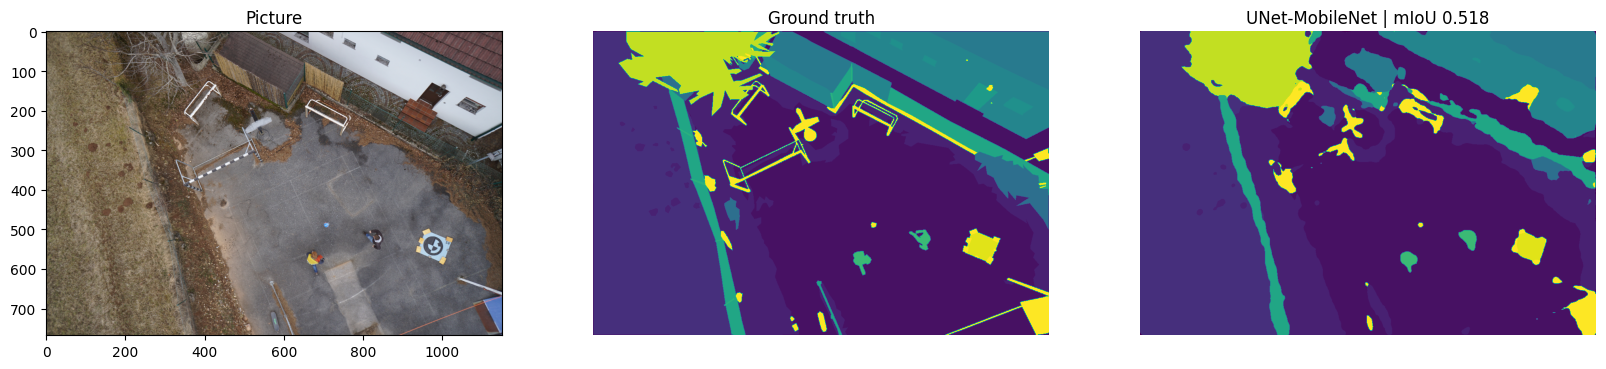

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture')

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

In [40]:
print('Test Set mIoU', np.mean(mob_miou))
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set mIoU 0.5223973229128079
Test Set Pixel Accuracy 0.8963284810384113
